In [115]:
#impoting the libs
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pe
#for word cloud

from wordcloud import WordCloud, STOPWORDS 
from sklearn import model_selection


import re
import string


from nltk.corpus import stopwords  
from nltk.stem.lancaster import LancasterStemmer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [116]:
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED =42
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
Colors = ['#f0d407','#fbec7e','#04345b','#596e3e','#948304','#2f524f']
sns.set_palette(sns.color_palette(Colors))
rcParams['figure.figsize']=12,8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



# Importing the csv's

In [117]:
train_df = pd.read_csv(r"D:\Datasets\toxic\train.csv")
test_df = pd.read_csv(r"D:\Datasets\toxic\test.csv")
test_lab_df = pd.read_csv(r"D:\Datasets\toxic\test_labels.csv")
sample_df = pd.read_csv(r"D:\Datasets\toxic\sample_submission.csv")


In [118]:
train_df.head(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [119]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [120]:
train_df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [121]:
test_df.head(6)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...


In [122]:
test_lab_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [123]:
sample_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [124]:
toxic_words = train_df.head(100)[train_df.head(5000).sum(axis=1)>=3]
toxic_words

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
65,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,1,0,1,0,1,0


#  EDA

In [131]:
train_df,val_df = model_selection.train_test_split(train_df,test_size=0.04)

In [132]:
train_df.shape,val_df.shape

((153188, 8), (6383, 8))

In [133]:
#creating cols for label
lable_cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [134]:
#now we are depecting the number of mesages which are of each type using bar graph
bar_c = pd.DataFrame(train_df[lable_cols].sum()).reset_index()
bar_c.columns = ['Type','Count']
fig = pe.bar(bar_c, x='Type', y='Count')
fig.show()

In [135]:
toxic_df = train_df[train_df[lable_cols].sum(axis=1)>0]
clean_df = train_df[train_df[lable_cols].sum(axis=1)==0]

train_df = pd.concat([
    toxic_df,
    clean_df.sample(15_000)
])

In [136]:
train_df.shape


(30572, 8)

In [137]:
sample_row = train_df[train_df.id=='0002bcb3da6cb337']
sample_row = sample_row.iloc[0]
sample_comment = sample_row.comment_text
sample_labels = sample_row[lable_cols]

print(sample_comment)
print()
print(sample_labels.to_dict())

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

{'toxic': 1, 'severe_toxic': 1, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}


In [138]:
test_df.shape

(153164, 2)

In [139]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,30572.000000,30572.000000,30572.000000,30572.000000,30572.000000,30572.000000
mean,0.480178,0.050111,0.265308,0.015275,0.246696,0.044125
std,0.499615,0.218178,0.441504,0.122648,0.431095,0.205377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data preprocessing

In [140]:
#import Natural language TOOLKIT
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [141]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [170]:
#importing re for the regular expression operation performed
import re
import string                              


 ## Removing all the number capital number puntuation 
 

In [171]:
def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [172]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean(x))
train_df['comment_text'].head()

133825    now you all know damn well my article on ninja...
88489     dreadstar     and some jerk on the internet ar...
152815    michael schiavo he is breaking wp   and you ac...
102324    does it ever dawn on you that you are the reas...
41344         the great one   i dont really have a probl...
Name: comment_text, dtype: object

In [173]:
test_df['comment_text'].head()

0    yo bitch ja rule is more succesful then youll ...
1            from rfc   the title is fine as it is imo
2              sources    zawe ashton on lapland —    
3    if you have a look back at the source the info...
4              i dont anonymously edit articles at all
Name: comment_text, dtype: object

In [174]:
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean(x))

In [175]:
test_df['comment_text'].head()

0    yo bitch ja rule is more succesful then youll ...
1            from rfc   the title is fine as it is imo
2              sources    zawe ashton on lapland —    
3    if you have a look back at the source the info...
4              i dont anonymously edit articles at all
Name: comment_text, dtype: object

### Bifercating our data set into sections

In [177]:
data_tox = train_df.loc[:,['id','comment_text','toxic']]




In [180]:
data_tox['comment_text'].head(1)

133825    now you all know damn well my article on ninja...
Name: comment_text, dtype: object

In [182]:
data_tox['comment_text'].head(2)

133825    now you all know damn well my article on ninja...
88489     dreadstar     and some jerk on the internet ar...
Name: comment_text, dtype: object

In [184]:
data_sev = train_df.loc[:,['id','comment_text','severe_toxic']]

In [186]:

data_obs = train_df.loc[:,['id','comment_text','obscene']]


In [187]:
data_thr = train_df.loc[:,['id','comment_text','threat']]

In [188]:
data_ins = train_df.loc[:,['id','comment_text','insult']]

In [189]:
data_ide = train_df.loc[:,['id','comment_text','identity_hate']]

In [190]:
def wordcloud(df):
    comment_words = ''   
    stopwords = set(STOPWORDS) 
    
    for val in df.comment_text: 
       
        val = str(val) 

        
        tokens = val.split() 

      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                stopwords=stopwords,
                min_font_size = 10).generate(comment_words) 


                            
    plt.figure(figsize = (8, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

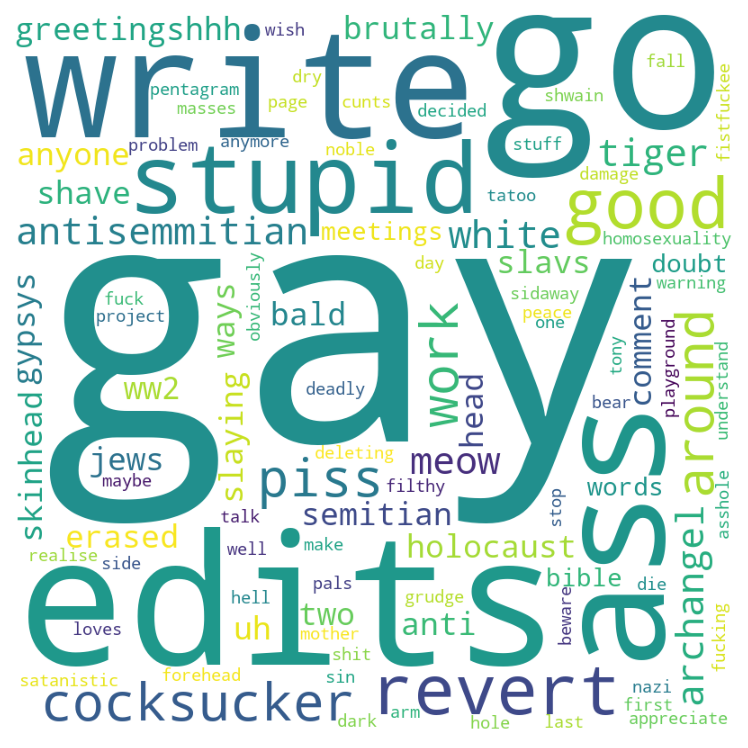

In [191]:
#showing the toxic words using word cloud
wordcloud(toxic_words)

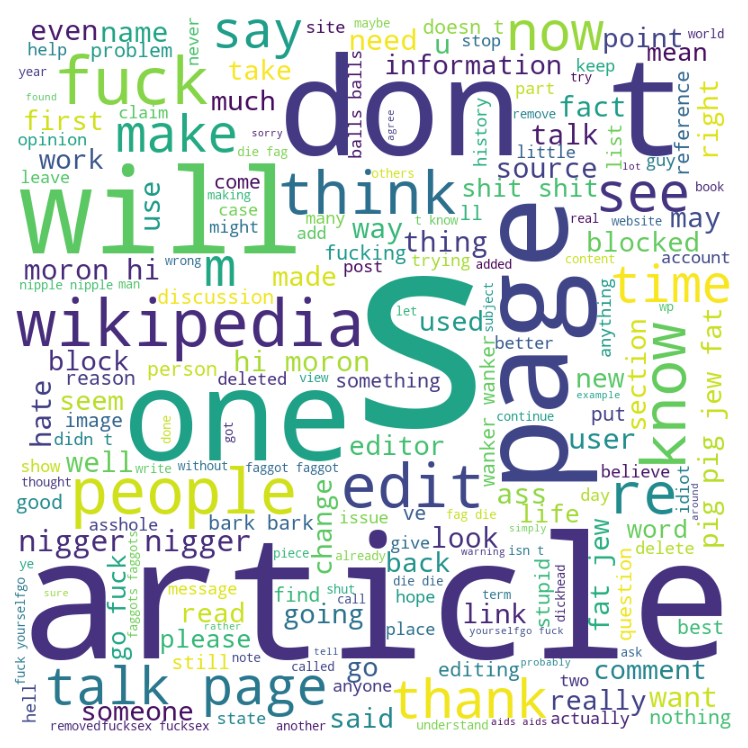

In [197]:
wordcloud(data_ide)

In [192]:
data_tox.head()

,id,comment_text,toxic
133825,cbf3a8cc0e661d24,now you all know damn well my article on ninja...,1
88489,ecb6184cd9faee4e,dreadstar and some jerk on the internet ar...,1
152815,92f11a941c90e3ef,michael schiavo he is breaking wp and you ac...,1
102324,2385804471928c58,does it ever dawn on you that you are the reas...,1
41344,6e41e91ac23dcd14,the great one i dont really have a probl...,0


In [193]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [194]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [195]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

In [201]:
# balancing the row
data_sev[data_sev['severe_toxic'] == 1].count()


id              1532
comment_text    1532
severe_toxic    1532
dtype: int64

In [202]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3127, 3)

In [203]:
data_obs[data_obs['obscene'] == 1].count()

id              8111
comment_text    8111
obscene         8111
dtype: int64

In [204]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [205]:
data_thr[data_thr['threat'] == 1].count()

id              467
comment_text    467
threat          467
dtype: int64

In [206]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2379, 3)

In [207]:
data_ins[data_ins['insult'] == 1].count()

id              7542
comment_text    7542
insult          7542
dtype: int64

In [208]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [209]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1349
comment_text     1349
identity_hate    1349
dtype: int64

In [210]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(6969, 3)

# Modelling

In [211]:
## In this we are going to calculate this on the basis of f1 score
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [213]:
def tf_train(df_done,label,vectorizer,ngram):

    
    # Split the data into X and y 
    X = df_done.comment_text
    y = df_done[label]

    # Split the data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) 
    X_test_cv1  = cv1.transform(X_test)      
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
   
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
   
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


In [214]:
import time

t0 = time.time()

df_tox = tf_train(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox

lr done
bnb done
mnb done
rdf done
Time taken: 7.917341709136963 seconds


,F1 Score(toxic)
Log Regression,0.814087
KNN,0.735504
BernoulliNB,0.739631
MultinomialNB,0.815405
SVM,0.806030
Random Forest,0.781116


In [215]:
t0 = time.time()

df_sev = tf_train(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev

lr done
bnb done
mnb done
rdf done
Time taken: 2.9727694988250732 seconds


,F1 Score(severe_toxic)
Log Regression,0.771775
KNN,0.660944
BernoulliNB,0.742097
MultinomialNB,0.794872
SVM,0.763521
Random Forest,0.784188


In [216]:
t0 = time.time()

df_obs = tf_train(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs

lr done
bnb done
mnb done
rdf done
Time taken: 8.077845811843872 seconds


,F1 Score(obscene)
Log Regression,0.786993
KNN,0.655301
BernoulliNB,0.715915
MultinomialNB,0.762672
SVM,0.785047
Random Forest,0.799862


In [217]:
t0 = time.time()

df_thr= tf_train(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr

lr done
bnb done
mnb done
rdf done
Time taken: 0.7417049407958984 seconds


,F1 Score(threat)
Log Regression,0.458537
KNN,0.493506
BernoulliNB,0.094675
MultinomialNB,0.121951
SVM,0.698039
Random Forest,0.638298


In [218]:
t0 = time.time()

df_ins = tf_train(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins

lr done
bnb done
mnb done
rdf done
Time taken: 9.078771114349365 seconds


,F1 Score(insult)
Log Regression,0.684397
KNN,0.274133
BernoulliNB,0.675603
MultinomialNB,0.663296
SVM,0.672967
Random Forest,0.692308


In [219]:
t0 = time.time()

df_ide = tf_train(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide

lr done
bnb done
mnb done
rdf done
Time taken: 3.6841928958892822 seconds


,F1 Score(identity_hate)
Log Regression,0.421793
KNN,0.368142
BernoulliNB,0.103896
MultinomialNB,0.059908
SVM,0.588235
Random Forest,0.592375


In [220]:
f1_all = pd.concat([df_tox, df_sev, df_obs, df_ins, df_thr, df_ide], axis=1)
f1_all

,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.814087,0.771775,0.786993,0.684397,0.458537,0.421793
KNN,0.735504,0.660944,0.655301,0.274133,0.493506,0.368142
BernoulliNB,0.739631,0.742097,0.715915,0.675603,0.094675,0.103896
MultinomialNB,0.815405,0.794872,0.762672,0.663296,0.121951,0.059908
SVM,0.806030,0.763521,0.785047,0.672967,0.698039,0.588235
Random Forest,0.781116,0.784188,0.799862,0.692308,0.638298,0.592375


In [221]:
f1_trans = f1_all.transpose()
f1_trans

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.814087,0.735504,0.739631,0.815405,0.806030,0.781116
F1 Score(severe_toxic),0.771775,0.660944,0.742097,0.794872,0.763521,0.784188
F1 Score(obscene),0.786993,0.655301,0.715915,0.762672,0.785047,0.799862
F1 Score(insult),0.684397,0.274133,0.675603,0.663296,0.672967,0.692308
F1 Score(threat),0.458537,0.493506,0.094675,0.121951,0.698039,0.638298
F1 Score(identity_hate),0.421793,0.368142,0.103896,0.059908,0.588235,0.592375


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

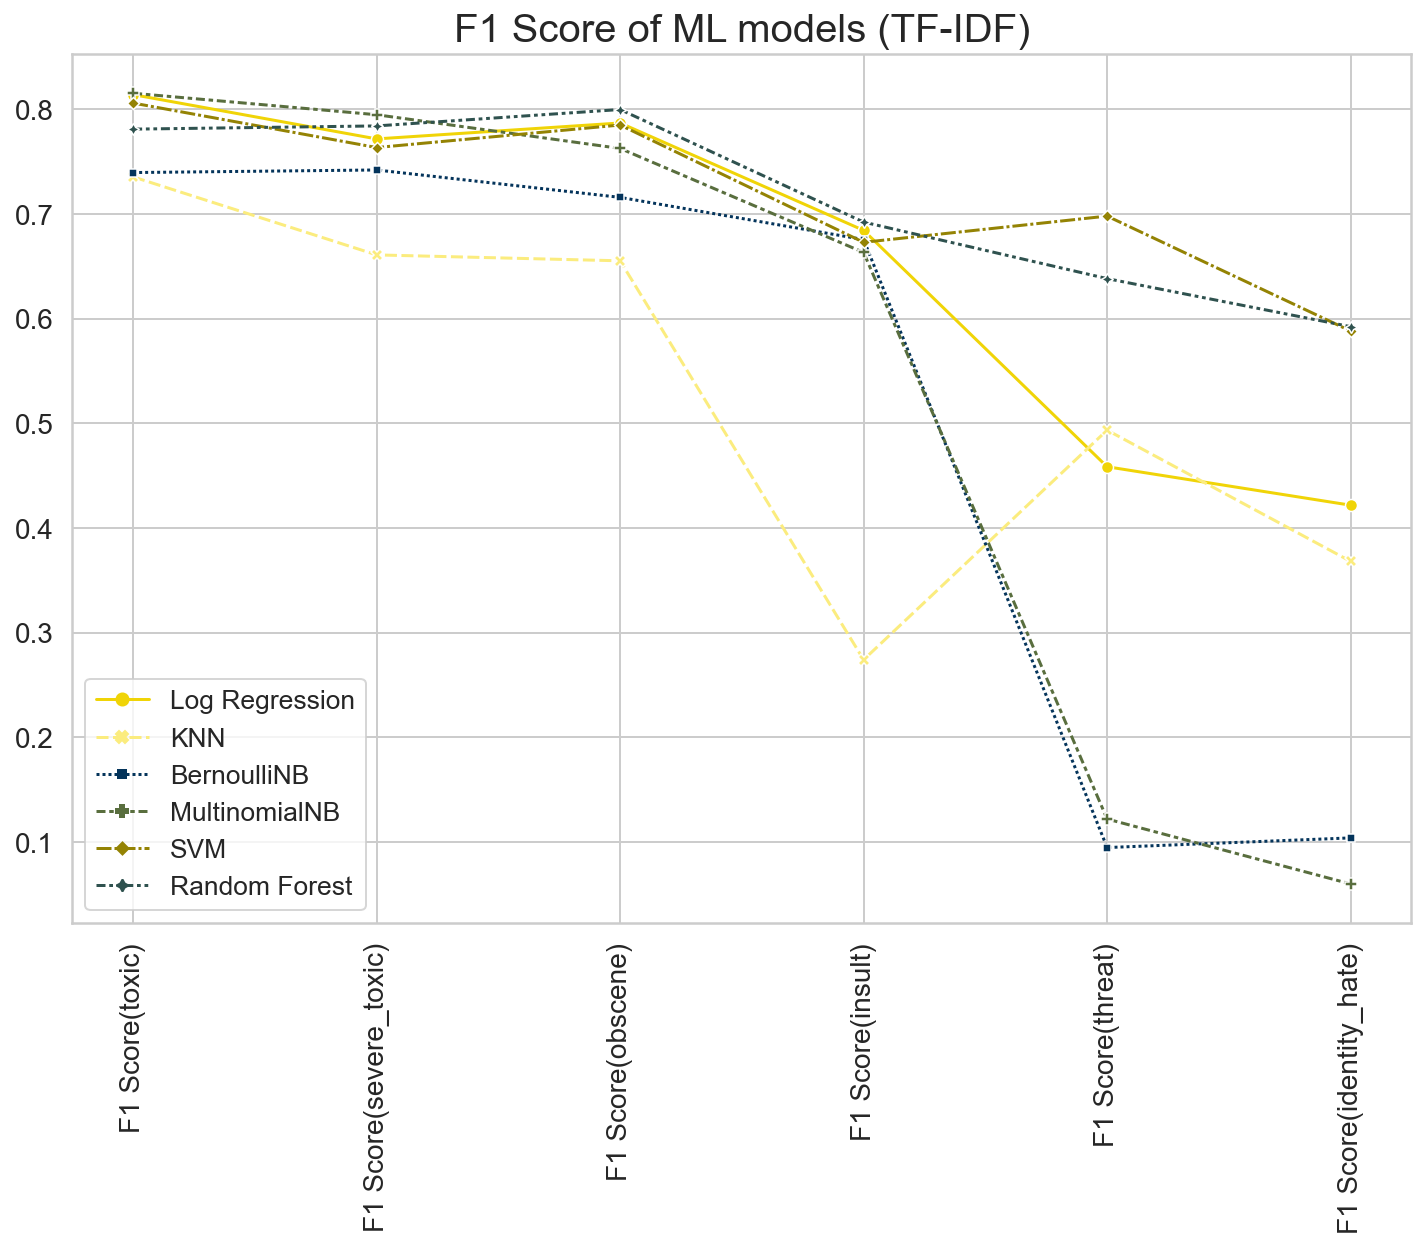

In [231]:

sns.lineplot(data=f1_trans, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# In this SVM Random forst are the best models

In [242]:
data_tox_done.head()

,id,comment_text,toxic
133825,cbf3a8cc0e661d24,now you all know damn well my article on ninja...,1
88489,ecb6184cd9faee4e,dreadstar and some jerk on the internet ar...,1
152815,92f11a941c90e3ef,michael schiavo he is breaking wp and you ac...,1
102324,2385804471928c58,does it ever dawn on you that you are the reas...,1
103999,2c69635cb9a2e01a,all russian are so dumm like you i mean you...,1


In [243]:
##using random forest
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [244]:
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([1.])

In [245]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.64])

In [246]:
import pickle

In [247]:
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_mod'), "wb") as f:  
        pickle.dump(randomforest, f)

In [248]:
datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)